## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import os
import sys
sys.path.append('./waveglow/')
import numpy as np
import torch
import transformers

from hparams import create_hparams
from model import Tacotron2
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser
from text.cleaners import text_normalize
from txt2pinyin import txt2pinyin

In [3]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [21]:
hparams = create_hparams()
# uncomment the following line if you want to use the original Tacotron 2
#hparams.bert = False
hparams.sampling_rate = 22050

#### Load model from checkpoint

In [22]:
# specify the path to the pre-trained Tacotron2
checkpoint_path = "../models/taco2/tacotron2_bert"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path))
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [23]:
# specify the path to the pre-trained Waveglow
waveglow_path = '../models/waveglow/waveglow_150k'
waveglow = torch.load(waveglow_path)
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
for m in waveglow.modules():
    if 'Conv' in str(type(m)):
        setattr(m, 'padding_mode', 'zeros')
denoiser = Denoiser(waveglow)

In [24]:
def load_bert(path):
    '''
    Load the Chinese Bert model in the specified folder
    '''
    config_path = os.path.join(path,'bert_config.json')
    model_path = os.path.join(path,'pytorch_model.bin')
    vocab_path = os.path.join(path, 'vocab.txt')
    
    
    config = transformers.BertConfig.from_pretrained(config_path)
    config.output_hidden_states=True
    
    model = transformers.BertModel.from_pretrained(model_path,config=config)
    model.eval()
    
    tokenizer = transformers.BertTokenizer(vocab_path)
    
    return model, tokenizer


def extract_embeddings(model,tokenizer,text,upsampling=True):
    '''
    Extract embeddings from the pre-trained bert model.
    Apply upsampling to ensure that embedding length are the same as the phoneme length
    '''
    
    clean_text = text_normalize(text)
    pinyin_seq = txt2pinyin(clean_text)
    phon_seq = [i for syl in pinyin_seq for i in syl]
    
    inputs = torch.tensor(tokenizer.encode(clean_text)).unsqueeze(0)
    outputs = model(inputs)    
    h = outputs[2][-1].cpu().detach().numpy()
#    del outputs
    
    
    assert h.shape[1] == len(pinyin_seq)

    features = [np.tile(h[:,i,:],[1,len(syl),1]) for i,syl in enumerate(pinyin_seq)]
    features = np.concatenate(features,axis=1)
    
    assert features.shape[1] == len(phon_seq)
    assert features.shape[2] == 768
    assert features.shape[0] == 1
    
    return torch.tensor(features).cuda().half()

if hparams.bert == True:
    # specify the path to the BERT folder
    bert_path = '../models/taco2/BZNSYP/chinese_wwm_ext_pytorch'
    bert, tokenizer= load_bert(bert_path)

I1223 15:28:21.546480 140615857555264 configuration_utils.py:148] loading configuration file ../models/taco2/BZNSYP/chinese_wwm_ext_pytorch/bert_config.json
I1223 15:28:21.547365 140615857555264 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 21128
}

I1223 15:28:21.548036 1406158

#### Prepare text input

In [25]:
text = "乔布斯想成为重要人物。"
sequence = np.array(text_to_sequence(text, ['chinese_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()
sequence

tensor([[136,  77,  27, 144, 138,  80, 205,  73,  29,  47, 164, 207, 129,  79,
         137,  42, 144, 209]], device='cuda:0')

In [26]:
if hparams.bert == True:
    features = extract_embeddings(bert,tokenizer,text)
    sequence = (sequence, features)

#### Decode text input and plot results

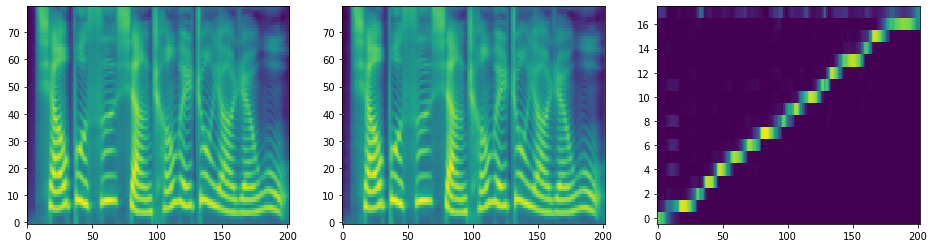

In [27]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [28]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)

ipd.Audio(np.concatenate((np.zeros(500),audio[0].data.cpu().numpy())), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [ ]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 